## 20 NG

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score as ss
from sklearn.manifold import TSNE
import plotly.express as px

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Fetch the 20 newsgroups dataset
newsgroups = fetch_20newsgroups(subset='all')

# Split the dataset into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(newsgroups.data, newsgroups.target, train_size=0.20, stratify=newsgroups.target,random_state=42)


# Vectorize the text data into a sparse matrix without common words
max_features = 5000  # Specify the maximum number of features
stop_words = 'english'  # Specify the set of common words
count_vect = CountVectorizer(max_features=max_features, stop_words=stop_words)
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)

# Apply TF-IDF transformation
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)


In [3]:
X = X_train_tfidf


In [4]:

# Compute pairwise Euclidean distances
distances = euclidean_distances(X)

# Step 3: Applying DBSCAN on the training set
dbscan = DBSCAN(eps=0.1, min_samples=3, metric='precomputed')

labels = dbscan.fit_predict(distances)
print(labels)
# Print the number of clusters and noise points in the training set
n_train_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_train_noise = list(labels).count(-1)


print("Number of clusters in training set:", n_train_clusters)
print("Number of noise points in training set:", n_train_noise)

# Compute silhouette scores if the number of clusters is greater than 2
if len(set(labels)) > 2:
    score  = ss(X.toarray(),labels)
    print("Score:", score)



[-1 -1 -1 ... -1 -1 -1]
Number of clusters in training set: 0
Number of noise points in training set: 3769


In [5]:
import numpy as np

epsilons = np.linspace(0.01,1.5,num=15)
epsilons

array([0.01      , 0.11642857, 0.22285714, 0.32928571, 0.43571429,
       0.54214286, 0.64857143, 0.755     , 0.86142857, 0.96785714,
       1.07428571, 1.18071429, 1.28714286, 1.39357143, 1.5       ])

In [6]:
min_samples =np.arange(1,15,step=1)
min_samples

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [7]:
import itertools 

combinations = list(itertools.product(epsilons, min_samples))

In [8]:

def get_scores_and_labels(combinations,X,k=None):
    """ This function looop through all combinations and get the scores and labels for each combination. and return the paremeters that produces k clusters or the next best approximation 
    Parameters
    """

    scores = []
    all_labels_lists = []

    for i, (eps,num_samples) in enumerate(combinations):
        dbscan_model = DBSCAN(eps=eps, min_samples=num_samples,metric='euclidean')
        labels = dbscan_model.fit(X).labels_
        labels_set = set(labels)
        num_clusters = len(labels_set)
        if -1 in labels_set:
            num_clusters -= 1

        if(num_clusters < 2) or (num_clusters >20):
            scores.append(-10)
            all_labels_lists.append('bad')
            c = (eps,num_samples)
            print(f'combinations {c} {i +1} of {len(combinations)} has {num_clusters} clusters. Movinng on')
            continue
        all_labels_lists.append(labels)
        scores.append(ss(X.toarray(),labels))
        print(f'Index: {i}, Combination: {eps}, Number of samples: {num_samples}, Scores: {scores[-1]}, Number of clusters: {num_clusters}')

    best_index = np.argmax(scores)
    best_parameters = combinations[best_index]
    best_labels = all_labels_lists[best_index]
    best_score = scores[best_index]

    return {'best_epsilon' : best_parameters[0], 
            'best_min_samples' : best_parameters[1],
            'best_labels' : best_labels,
            'best_score' : best_score}
            

        

In [9]:
best_dict = get_scores_and_labels(combinations,X,20)

combinations (0.01, 1) 1 of 210 has 3767 clusters. Movinng on
Index: 1, Combination: 0.01, Number of samples: 2, Scores: -0.003952446194020178, Number of clusters: 2
combinations (0.01, 3) 3 of 210 has 0 clusters. Movinng on
combinations (0.01, 4) 4 of 210 has 0 clusters. Movinng on
combinations (0.01, 5) 5 of 210 has 0 clusters. Movinng on
combinations (0.01, 6) 6 of 210 has 0 clusters. Movinng on
combinations (0.01, 7) 7 of 210 has 0 clusters. Movinng on
combinations (0.01, 8) 8 of 210 has 0 clusters. Movinng on
combinations (0.01, 9) 9 of 210 has 0 clusters. Movinng on
combinations (0.01, 10) 10 of 210 has 0 clusters. Movinng on
combinations (0.01, 11) 11 of 210 has 0 clusters. Movinng on
combinations (0.01, 12) 12 of 210 has 0 clusters. Movinng on
combinations (0.01, 13) 13 of 210 has 0 clusters. Movinng on
combinations (0.01, 14) 14 of 210 has 0 clusters. Movinng on
combinations (0.11642857142857142, 1) 15 of 210 has 3763 clusters. Movinng on
Index: 15, Combination: 0.116428571428

In [10]:
print(best_dict)

{'best_epsilon': 0.6485714285714286, 'best_min_samples': 4, 'best_labels': array([-1, -1, -1, ..., -1, -1, -1], dtype=int64), 'best_score': 0.006154150798220846}


In [11]:
# Step 4: Apply DBSCAN
eps = best_dict['best_epsilon']
min_samples = best_dict['best_min_samples']

dbscan = DBSCAN(eps=eps, min_samples=min_samples,metric='euclidean')
dbscan.fit(X)

labels = dbscan.labels_
unique_labels,counts = np.unique(labels,return_counts=True)

# Print the label counts
for label, count in zip(unique_labels, counts):
    print("Label:", label, "Count:", count)

Label: -1 Count: 3760
Label: 0 Count: 4
Label: 1 Count: 5


In [17]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

In [18]:
# Plot the t-SNE visualization
fig = px.scatter(X_tsne[:, 0], X_tsne[:, 1], color=labels)
fig.update_layout(title = "t-SNE Visualization of 20 Newsgroups Dataset")
fig.show()

## Back testing with best epsilon and best alpha min sample

## FASHION dataset

c:\Users\twahirwa.h\AppData\Local\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


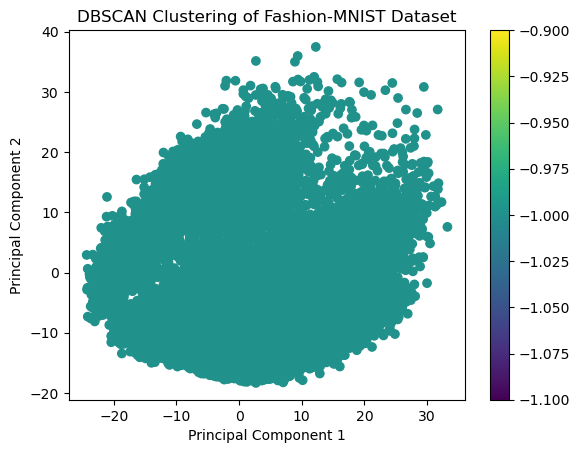

Number of clusters: 0
Number of noise points: 14000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml

# Step 1: Load the Fashion-MNIST dataset
fashion_mnist = fetch_openml(name='Fashion-MNIST')

X_train, X_test, y_train, y_test = train_test_split(fashion_mnist.data, fashion_mnist.target, test_size=0.8, stratify=fashion_mnist.target, random_state=42)

X = X_train
y = y_train

# Step 2: Preprocess the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 4: Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X_scaled)

labels = dbscan.labels_

# Step 5: Visualize the clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.title('DBSCAN Clustering of Fashion-MNIST Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

# Step 6: Evaluate the clustering results
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print("Number of clusters:", n_clusters)
print("Number of noise points:", n_noise)
